In [9]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

rcParams['figure.figsize'] = (13, 6)


train = DataSet(r'E:\重庆师范大学\研一上\非侵入式负荷检测\program\data\ukdale_h5\ukdale.h5')
test = DataSet(r'E:\重庆师范大学\研一上\非侵入式负荷检测\program\data\ukdale_h5\ukdale.h5')

In [24]:

building = 1

train.set_window(end="2013-04-30")
test.set_window(start="2013-04-30")

train_elec_top_4 = train.buildings[2].elec.select_top_k(6) 
test_elec = test.buildings[2].elec

19/19 ElecMeter(instance=20, building=2, dataset='UK-DALE', site_meter, appliances=[])='cooker', instance=1)])ce=1)])]))

In [25]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power',  ac_type = 'active',sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall


In [26]:

classifiers = {'CO':CombinatorialOptimisation(),'FHMM':FHMM()}
predictions = {}
sample_period = 240
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(train_elec_top_4, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])
    

********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='UK-DALE', appliances=[Appliance(type='broadband router', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])'


f:\Anaconda\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
f:\Anaconda\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done training!
Runtime = 7.487241983413696 seconds.
Estimating power demand for 'ElecMeter(instance=5, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=2, dataset='UK-DALE', appliances=[Appliance(type='broadband router', instance=1)])'
Estimating power demand for 'ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])'
********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=5, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3,

f:\Anaconda\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
f:\Anaconda\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])' with 3 states
Runtime = 5.865593433380127 seconds.


In [28]:

appliance_labels = [m.label() for m in gt.columns.values]

gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

gt.head()

,Computer,Computer monitor,Broadband router,Laptop computer,Kettle
2013-05-21 11:52:00+01:00,13.058824,61.352940,6.176471,22.529411,1.000000
2013-05-21 11:56:00+01:00,13.025641,61.461540,6.179487,29.153847,0.923077
2013-05-21 12:00:00+01:00,12.974359,61.076923,6.051282,22.205128,0.923077
2013-05-21 12:04:00+01:00,12.769231,61.179485,6.076923,23.615385,1.000000
2013-05-21 12:08:00+01:00,12.897436,61.153847,6.102564,22.717949,0.871795


In [29]:
predictions['CO'].head()

,Computer,Computer monitor,Broadband router,Laptop computer,Kettle
2013-05-21 11:52:00+01:00,39.0,61.0,23.0,48.0,0.0
2013-05-21 11:56:00+01:00,39.0,61.0,23.0,48.0,0.0
2013-05-21 12:00:00+01:00,39.0,61.0,23.0,48.0,0.0
2013-05-21 12:04:00+01:00,39.0,61.0,23.0,48.0,0.0
2013-05-21 12:08:00+01:00,39.0,61.0,23.0,48.0,0.0


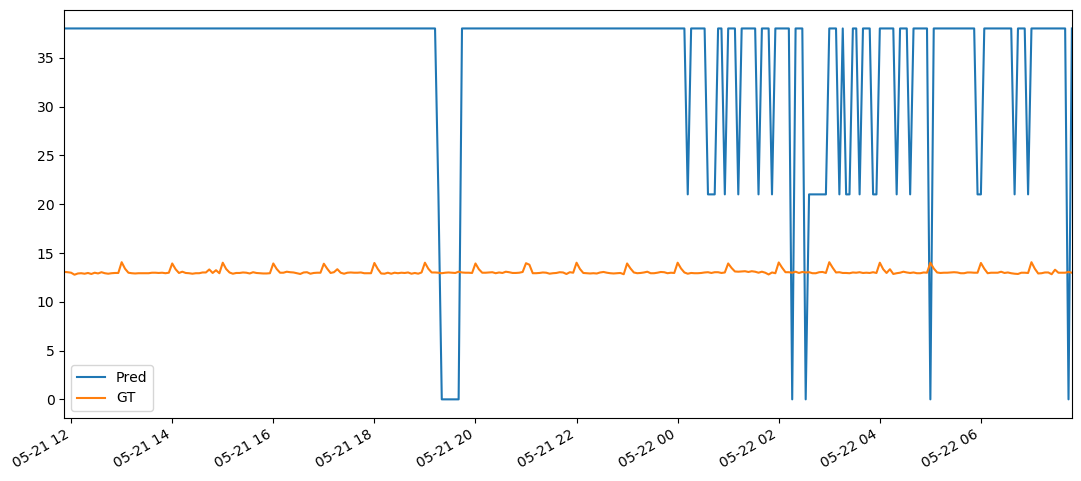

In [16]:
predictions['CO']["Computer"].head(300).plot(label="Pred")
gt["Computer"].head(300).plot(label="GT")
plt.legend()

In [33]:
predictions['FHMM'].head()

,Computer,Computer monitor,Broadband router,Laptop computer,Kettle
2013-05-21 11:52:00+01:00,38.0,61.0,124.0,15.0,0.0
2013-05-21 11:56:00+01:00,38.0,61.0,124.0,36.0,0.0
2013-05-21 12:00:00+01:00,38.0,61.0,124.0,15.0,0.0
2013-05-21 12:04:00+01:00,38.0,61.0,124.0,36.0,0.0
2013-05-21 12:08:00+01:00,67.0,61.0,124.0,36.0,0.0


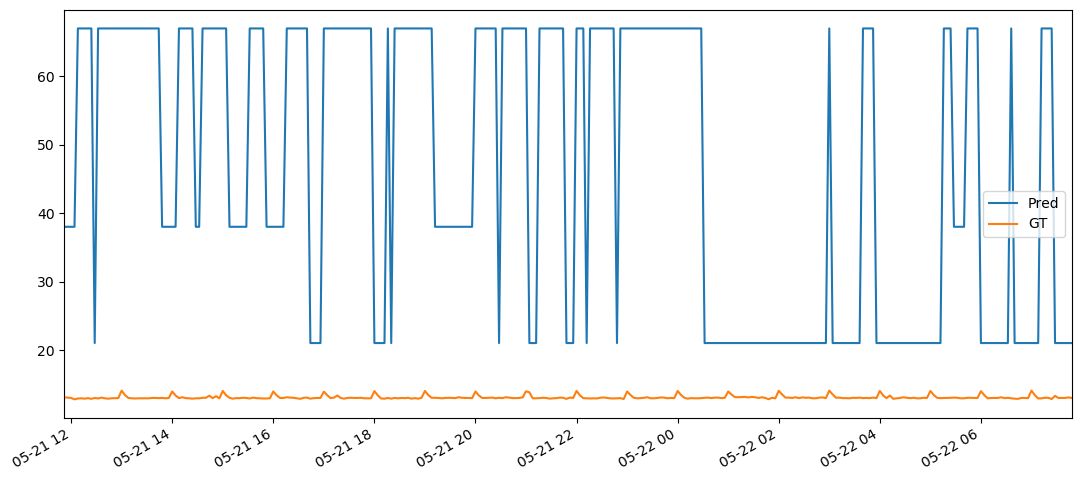

In [30]:
predictions['FHMM']['Computer'].head(300).plot(label="Pred")
gt['Computer'].head(300).plot(label="GT")
plt.legend()

In [34]:
from nilmtk.utils import compute_rmse

rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse    


,CO,FHMM
Computer,23.405464,37.510401
Computer monitor,51.288399,36.811679
Broadband router,15.529733,106.248324
Laptop computer,39.023064,20.151227
Kettle,353.752411,328.634509
